# 4. Linear Neural Networks for Classification

## 4.1 SoftMax Regression

## 4.2 The Image Classification Dataset

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [2]:
class FashionMNIST(d2l.DataModule):
    """The Fashion-MNIST dataset.

    Defined in :numref:`sec_fashion_mnist`"""

    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True
        )
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True
        )

    def text_labels(self, indices):
        """Return text labels.

        Defined in :numref:`sec_fashion_mnist`"""
        labels = [
            "t-shirt",
            "trouser",
            "pullover",
            "dress",
            "coat",
            "sandal",
            "shirt",
            "sneaker",
            "bag",
            "ankle boot",
        ]
        return [labels[int(i)] for i in indices]

    def get_dataloader(self, train):
        """Defined in :numref:`sec_fashion_mnist`"""
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(
            data, self.batch_size, shuffle=train, num_workers=self.num_workers
        )

    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        """Defined in :numref:`sec_fashion_mnist`"""
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)

## 4.3 The Base Classification Model

In [3]:
class Classifier(d2l.Module):
    """The base class of classification models.

    Defined in :numref:`sec_classification`"""

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot("loss", self.loss(Y_hat, batch[-1]), train=False)
        self.plot("acc", self.accuracy(Y_hat, batch[-1]), train=False)

    def accuracy(self, Y_hat, Y, averaged=True):
        """Compute the number of correct predictions.

        Defined in :numref:`sec_classification`"""
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        preds = d2l.astype(d2l.argmax(Y_hat, axis=1), Y.dtype)
        compare = d2l.astype(preds == d2l.reshape(Y, -1), d2l.float32)
        return d2l.reduce_mean(compare) if averaged else compare

    def loss(self, Y_hat, Y, averaged=True):
        """Defined in :numref:`sec_softmax_concise`"""
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = d2l.reshape(Y, (-1,))
        return F.cross_entropy(Y_hat, Y, reduction="mean" if averaged else "none")

    def layer_summary(self, X_shape):
        """Defined in :numref:`sec_lenet`"""
        X = d2l.randn(*X_shape)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, "output shape:\t", X.shape)

## 4.5 Concise Implementation of Softmax Regression

In [4]:
class Trainer(d2l.HyperParameters):
    """The base class for training models with data.

    Defined in :numref:`subsec_oo-design-models`"""

    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        """Defined in :numref:`sec_use_gpu`"""
        self.save_hyperparameters()
        self.gpus = [d2l.gpu(i) for i in range(min(num_gpus, d2l.num_gpus()))]

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (
            len(self.val_dataloader) if self.val_dataloader is not None else 0
        )

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        """Defined in :numref:`sec_linear_scratch`"""
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1

    def prepare_batch(self, batch):
        """Defined in :numref:`sec_use_gpu`"""
        if self.gpus:
            batch = [d2l.to(a, self.gpus[0]) for a in batch]
        return batch

    def prepare_model(self, model):
        """Defined in :numref:`sec_use_gpu`"""
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        if self.gpus:
            model.to(self.gpus[0])
        self.model = model

    def clip_gradients(self, grad_clip_val, model):
        """Defined in :numref:`sec_rnn-scratch`"""
        params = [p for p in model.parameters() if p.requires_grad]
        norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
        if norm > grad_clip_val:
            for param in params:
                param.grad[:] *= grad_clip_val / norm

In [5]:
class SoftmaxRegression(Classifier):  # @save
    """The softmax regression model."""

    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.Linear(784, num_outputs), nn.LazyLinear(num_outputs)
        )

    def forward(self, X):
        return self.net(X)

    def loss(self, Y_hat, Y, averaged=True):
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        Y = Y.reshape((-1,))
        return F.cross_entropy(Y_hat, Y, reduction="mean" if averaged else "none")

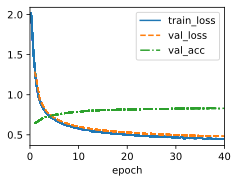

In [7]:
data = FashionMNIST(batch_size=512)
model = SoftmaxRegression(num_outputs=10, lr=0.02)
trainer = Trainer(max_epochs=40, num_gpus=2)
trainer.fit(model, data)

## My own implementation of Softmax Regression

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms as T

import datetime

### Data

In [3]:
class FashionMNIST():
    def __init__(self, root: str = './data', batch_size=64, resize=(28, 28)) -> None:
        self.root = root
        self.batch_size = batch_size
        transformations = T.Compose([T.Resize(resize), T.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=transformations, download=True
        )
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=transformations, download=True
        )
    
    def get_dataloader(self, train: bool):
        """
        The DataLoader allows us to iterate over the dataset in batches.
        """
        dataset = self.train if train else self.val
        return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=train)

### Model

In [4]:
class SoftmaxRegression(nn.Module):
    def __init__(self, num_outputs: int):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(784, num_outputs)
        self.lazy_linear = nn.LazyLinear(num_outputs)
        self.nn_log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.flatten(x)
        out = self.linear(out)
        out = F.tanh(self.lazy_linear(out))
        return out


### Training

In [5]:
def train(n_epochs, optimizer, model, loss_fn, train_loader):
    device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    model.to(device)
    print(f"Training on {device}")

    for epoch in range(n_epochs):
        train_loss = 0.0
        for images, labels in train_loader:
            # Move the images and labels to the device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the training loss
            train_loss += loss.item()
        
        if epoch % 10 == 0:
            print(f"{datetime.datetime.now()} - Epoch {epoch} - Training loss: {train_loss / len(train_loader)}")


In [10]:
learning_rate = 1e-2

model = SoftmaxRegression(num_outputs=10)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_fn = F.cross_entropy

/home/jmendoza/rnns-project/.venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [11]:
data_loader = FashionMNIST(batch_size=64)

train_loader = data_loader.get_dataloader(train=True)
val_loader = data_loader.get_dataloader(train=False)

In [12]:
len(data_loader.train)

60000

In [13]:
train(n_epochs=100, optimizer=optimizer, model=model, loss_fn=loss_fn, train_loader=train_loader)

Training on cuda
2024-11-07 21:00:49.991116 - Epoch 0 - Training loss: 1.19186754686746
2024-11-07 21:01:54.237464 - Epoch 10 - Training loss: 1.098226498629747
2024-11-07 21:02:58.496860 - Epoch 20 - Training loss: 1.1015137006351943
2024-11-07 21:04:02.560424 - Epoch 30 - Training loss: 1.088352300337891


KeyboardInterrupt: 

### Validation

In [ ]:
def validate(model, train_loader, val_loader):
    device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    model.to(device)
    print(f"Validation on {device}")

    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f"Accuracy {name}: {correct / total}")

In [ ]:
validate(model, train_loader, val_loader)